In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime
import json

from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam

print("TensorFlow:", tf.__version__)


TensorFlow: 2.20.0


In [2]:
df_ton = pd.read_csv("train_test_network.csv")

print("TON_IoT shape:", df_ton.shape)
df_ton.head()


TON_IoT shape: (211043, 44)


,src_ip,src_port,dst_ip,dst_port,proto,service,duration,src_bytes,dst_bytes,conn_state,...,http_response_body_len,http_status_code,http_user_agent,http_orig_mime_types,http_resp_mime_types,weird_name,weird_addl,weird_notice,label,type
0,192.168.1.37,4444,192.168.1.193,49178,tcp,-,290.371539,101568,2592,OTH,...,0,0,-,-,-,-,-,-,1,backdoor
1,192.168.1.193,49180,192.168.1.37,8080,tcp,-,0.000102,0,0,REJ,...,0,0,-,-,-,-,-,-,1,backdoor
2,192.168.1.193,49180,192.168.1.37,8080,tcp,-,0.000148,0,0,REJ,...,0,0,-,-,-,-,-,-,1,backdoor
3,192.168.1.193,49180,192.168.1.37,8080,tcp,-,0.000113,0,0,REJ,...,0,0,-,-,-,-,-,-,1,backdoor
4,192.168.1.193,49180,192.168.1.37,8080,tcp,-,0.000130,0,0,REJ,...,0,0,-,-,-,-,-,-,1,backdoor


In [3]:
df_ton_benign = df_ton[df_ton["label"] == 0].copy()

print("TON_IoT benign samples:", df_ton_benign.shape)


TON_IoT benign samples: (50000, 44)


In [4]:
UNIFIED_FEATURES = [
    "flow_duration_log",
    "traffic_volume_log",
    "traffic_rate_log",
    "packet_count_log",
    "protocol_tcp",
    "protocol_udp",
    "protocol_http"
]


In [5]:
def project_ton_to_unified(df):
    df = df.copy()

    total_bytes = df["src_bytes"] + df["dst_bytes"]
    total_pkts  = df["src_pkts"] + df["dst_pkts"]

    df["flow_duration_log"] = np.log1p(df["duration"])
    df["traffic_volume_log"] = np.log1p(total_bytes)
    df["packet_count_log"] = np.log1p(total_pkts)
    df["traffic_rate_log"] = np.log1p(
        total_bytes / (df["duration"] + 1e-6)
    )

    df["protocol_tcp"] = (df["proto"].str.lower() == "tcp").astype(int)
    df["protocol_udp"] = (df["proto"].str.lower() == "udp").astype(int)
    df["protocol_http"] = df["proto"].str.lower().isin(["http", "https"]).astype(int)

    return df[UNIFIED_FEATURES]


In [6]:
def build_autoencoder(input_dim):
    inputs = Input(shape=(input_dim,))
    x = Dense(64, activation="relu")(inputs)
    x = Dropout(0.2)(x)
    x = Dense(32, activation="relu")(x)
    latent = Dense(16, activation="relu")(x)

    x = Dense(32, activation="relu")(latent)
    x = Dropout(0.2)(x)
    x = Dense(64, activation="relu")(x)
    outputs = Dense(input_dim)(x)

    model = Model(inputs, outputs)
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss="mse"
    )
    return model


In [7]:
protocols = ["tcp", "udp"]

protocol_datasets = {}

for proto in protocols:
    df_p = df_ton_benign[df_ton_benign["proto"].str.lower() == proto]

    print(f"{proto.upper()} benign samples:", df_p.shape[0])

    if df_p.shape[0] > 1000:
        protocol_datasets[proto] = df_p.copy()


TCP benign samples: 18203
UDP benign samples: 31673


In [8]:
MODEL_DIR = Path.cwd().parent / "models"
MODEL_DIR.mkdir(parents=True, exist_ok=True)

protocol_models = {}

for proto, df_p in protocol_datasets.items():
    print(f"\nTraining {proto.upper()} baseline...")

    X_p = project_ton_to_unified(df_p)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_p)

    model = build_autoencoder(input_dim=X_scaled.shape[1])

    history = model.fit(
        X_scaled, X_scaled,
        epochs=20,
        batch_size=128,
        validation_split=0.1,
        shuffle=True,
        verbose=1
    )

    protocol_models[proto] = {
        "model": model,
        "scaler": scaler
    }

    # Save model
    model_path = MODEL_DIR / f"ae_{proto}_v1.keras"
    model.save(model_path)

    # Save metadata
    metadata = {
        "baseline_id": f"ae_{proto}_v1",
        "baseline_type": "per_protocol",
        "protocol": proto,
        "model_type": "deep_autoencoder",
        "features": UNIFIED_FEATURES,
        "training_samples": len(X_p),
        "created_at": datetime.now().isoformat()
    }

    meta_path = MODEL_DIR / f"ae_{proto}_v1_meta.json"
    with open(meta_path, "w") as f:
        json.dump(metadata, f, indent=4)

    print(f"Saved {proto.upper()} baseline →", model_path)



Training TCP baseline...
Epoch 1/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.1738 - val_loss: 0.0034
Epoch 2/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0347 - val_loss: 0.0032
Epoch 3/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0258 - val_loss: 0.0046
Epoch 4/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0206 - val_loss: 0.0062
Epoch 5/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0176 - val_loss: 0.0065
Epoch 6/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0155 - val_loss: 0.0060
Epoch 7/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0134 - val_loss: 0.0074
Epoch 8/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0124 - val_loss: 0.0063
Epoch 9/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0105 - val_loss: 0.0070
Epoch 10/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0105 - val_loss: 0.0078
Epoch 11/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0089 - val_loss: 0.0091
Epoch 12/20
128/128 ━━━━━━

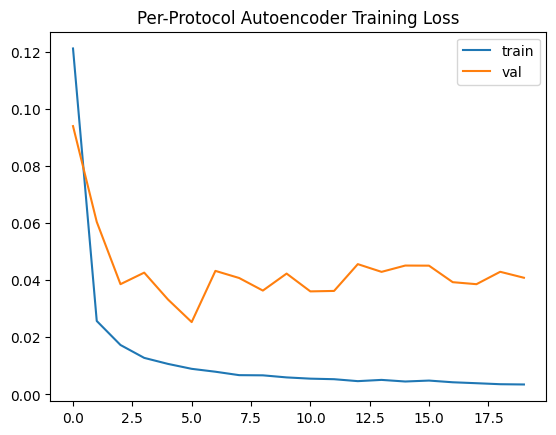

In [9]:
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="val")
plt.title("Per-Protocol Autoencoder Training Loss")
plt.legend()
plt.show()


In [10]:
def select_baseline(event_proto, protocol_models, global_model=None):
    proto = event_proto.lower()
    if proto in protocol_models:
        return protocol_models[proto]["model"], protocol_models[proto]["scaler"]
    return global_model, None


In [11]:
for proto in protocol_models:
    print(f"✔ Baseline trained for protocol: {proto.upper()}")


✔ Baseline trained for protocol: TCP
✔ Baseline trained for protocol: UDP
